In [37]:
import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy.stats as st
import matplotlib.dates as mdates
from tabulate import tabulate
import os

import statsmodels


In [38]:
sns.set()
matplotlib.rcParams['figure.figsize'] = (12, 7)
pd.set_option('display.float_format','{:.4f}'.format)

# Kurs walut

[*********************100%***********************]  1 of 1 completed


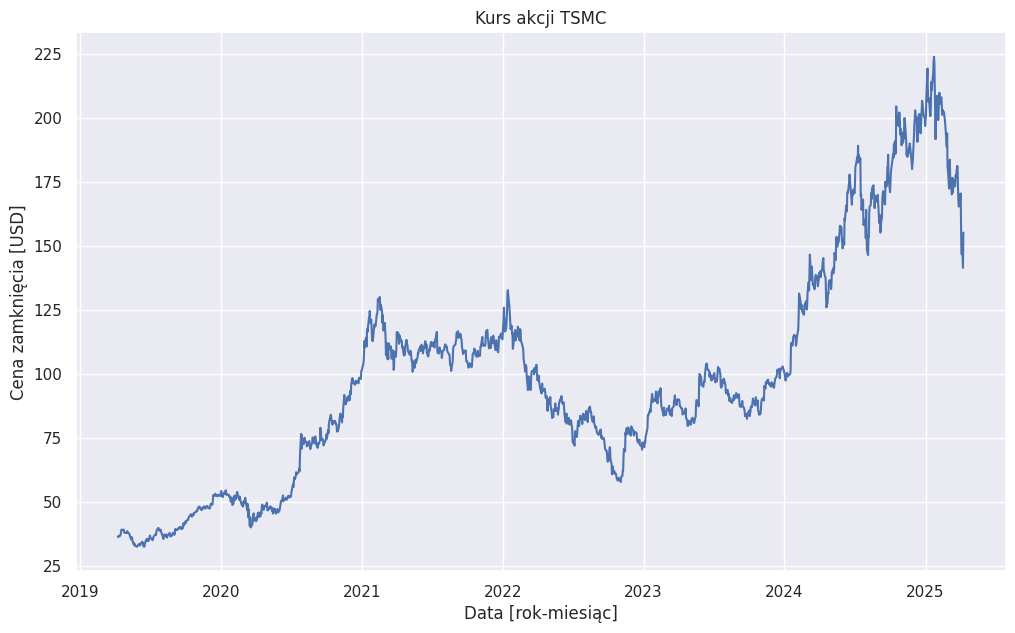

In [39]:
tsmc_data = yf.download('TSM', period = '6y')
tsmc_data = tsmc_data['Close']

plt.plot(tsmc_data)
plt.title('Kurs akcji TSMC')
plt.ylabel('Cena zamknięcia [USD]')
plt.xlabel('Data [rok-miesiąc]')
plt.grid(True)
plt.show()

[*********************100%***********************]  1 of 1 completed


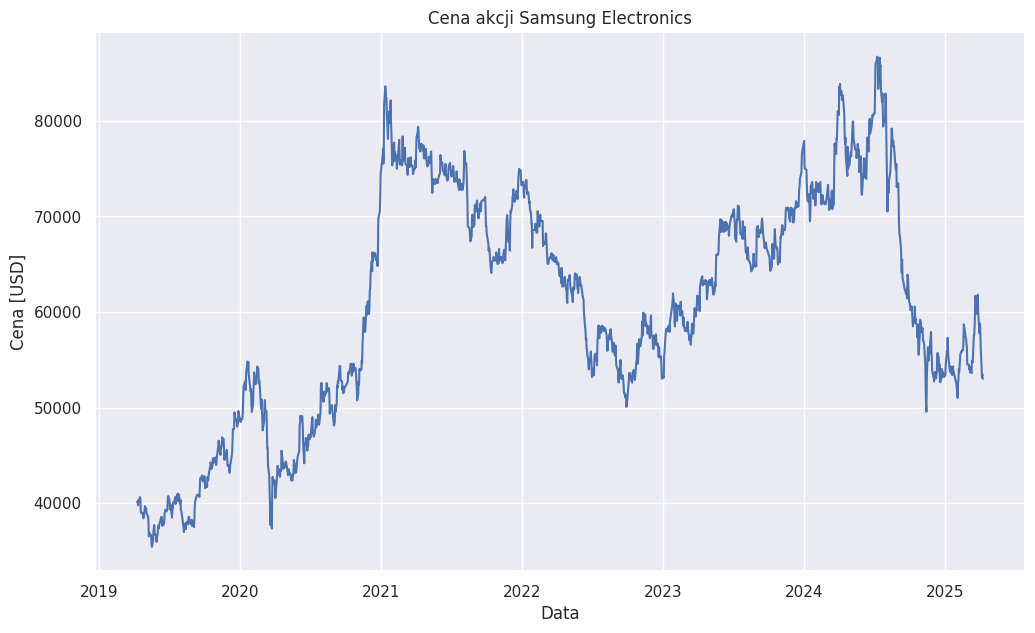

In [40]:
samsung = yf.download('005930.KS', period='6y')['Close']

plt.plot(samsung)
plt.title('Cena akcji Samsung Electronics')
plt.ylabel('Cena [USD]')
plt.xlabel('Data')
plt.grid(True)
plt.show()

In [41]:
log_returns_tsmc = np.log(tsmc_data / tsmc_data.shift(1)).dropna() * 100
log_returns_samsung = np.log(samsung / samsung.shift(1)).dropna() * 100

# Maksima miesięczne (tylko dodatnie zwroty)


In [42]:
pos_returns_tsmc = log_returns_tsmc[log_returns_tsmc > 0]
pos_returns_samsung = log_returns_samsung[log_returns_samsung > 0]

# 2. Grupujemy po miesiącach i znajdujemy indeksy (daty) maksimów
max_dates_tsmc = pos_returns_tsmc.groupby(pos_returns_tsmc.index.to_period("M")).idxmax()
max_dates_samsung = pos_returns_samsung.groupby(pos_returns_samsung.index.to_period("M")).idxmax()

# 3. Pobieramy wartości ekstremalne dla tych rzeczywistych dat
monthly_maxima_tsmc = log_returns_tsmc.loc[np.ravel(max_dates_tsmc)]
monthly_maxima_samsung = log_returns_samsung.loc[np.ravel(max_dates_samsung)]

In [43]:
start_date = log_returns_samsung.index.min().to_period('M').start_time
end_date = log_returns_samsung.index.max().to_period('M').end_time
month_starts = pd.date_range(start=start_date, end=end_date, freq='MS')

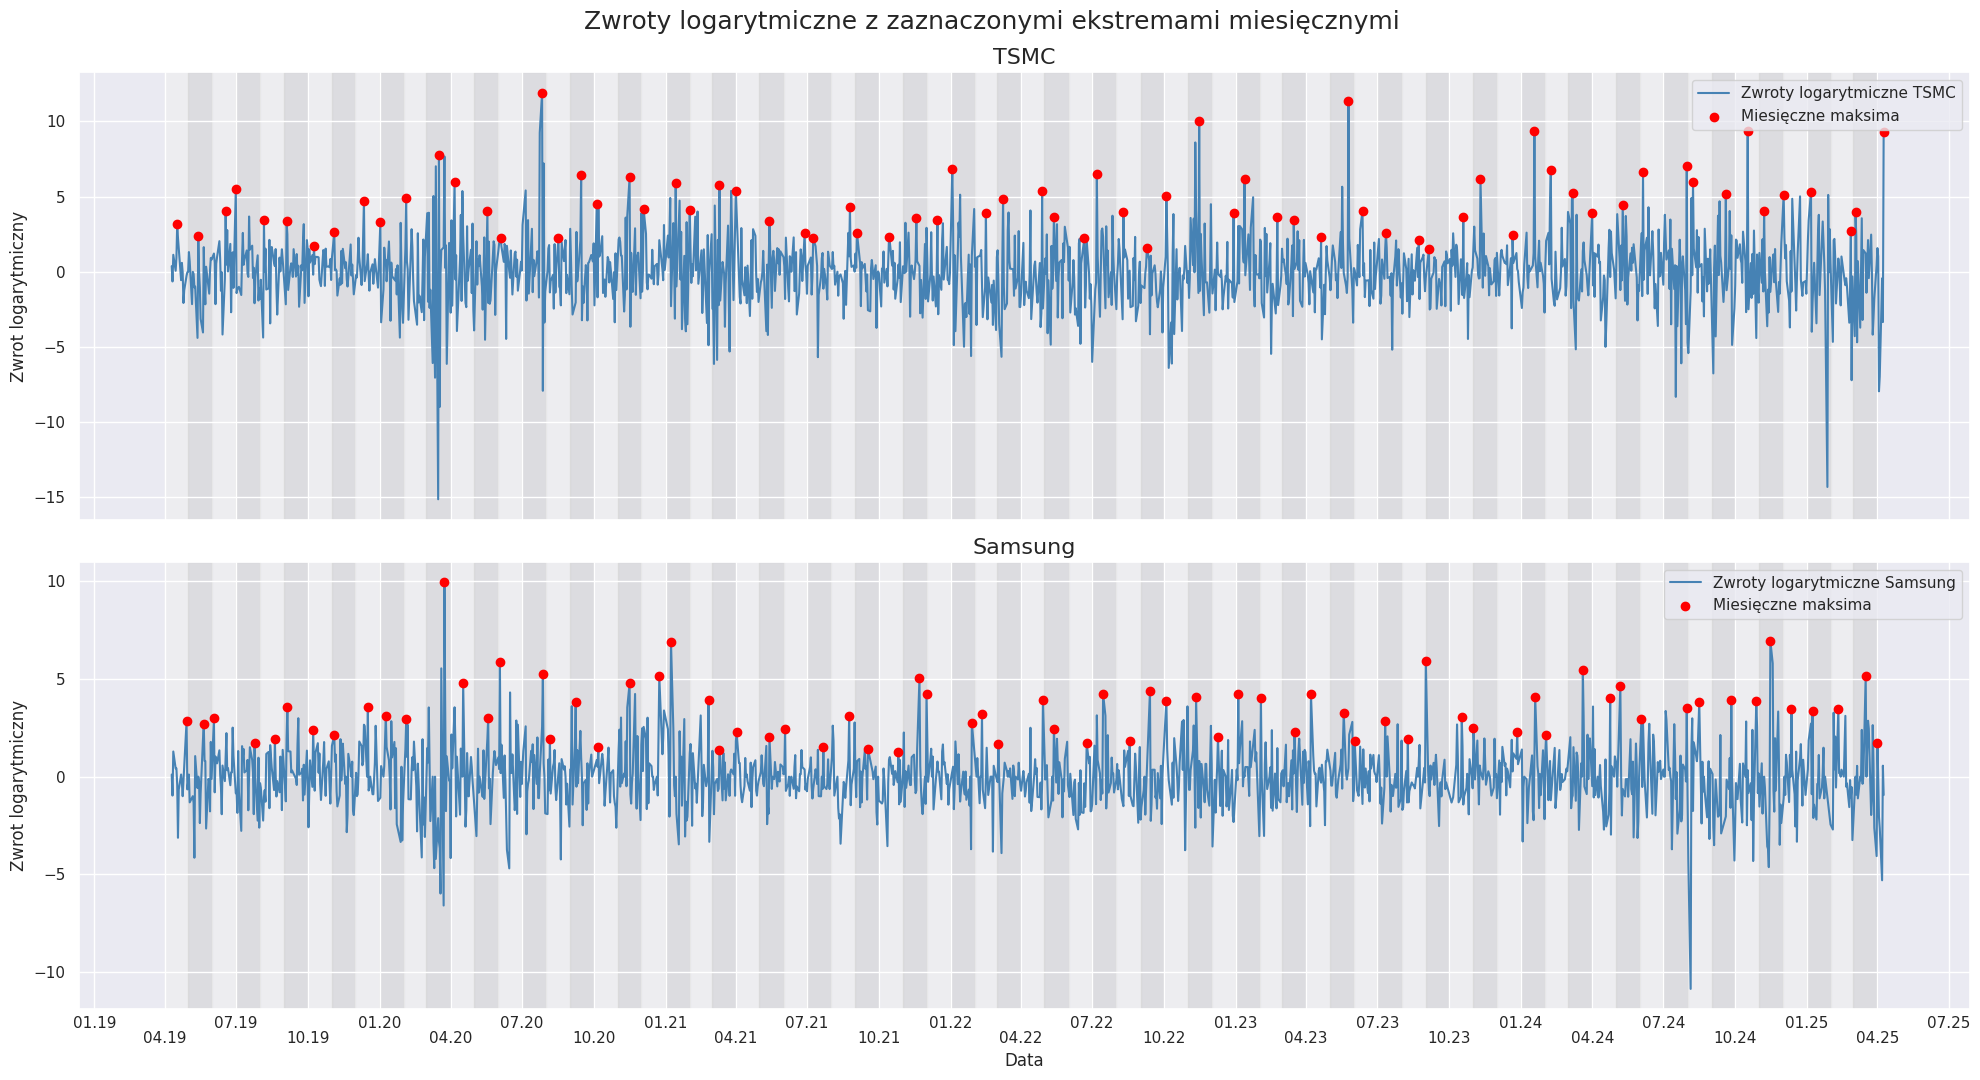

In [44]:
# Tworzenie wykresów z dwoma subplota
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 11), sharex=True)

# Naprzemienne tło: szary / mocniejszy szary
for i in range(len(month_starts) - 1):
    color = '#f0f0f0' if i % 2 == 0 else '#d0d0d0'
    ax1.axvspan(month_starts[i], month_starts[i+1], color=color, alpha=0.5, zorder=0)
    ax2.axvspan(month_starts[i], month_starts[i+1], color=color, alpha=0.5, zorder=0)

# Wykres górny (log_returns_usd_twd)
ax1.plot(log_returns_tsmc, color='steelblue', label='Zwroty logarytmiczne TSMC', zorder=1)
ax1.scatter(monthly_maxima_tsmc.index, monthly_maxima_tsmc.values, color='red', label='Miesięczne maksima', zorder=2)
ax1.set_title('TSMC', fontsize=16)
ax1.set_ylabel('Zwrot logarytmiczny')

# Wykres dolny (log_returns_samsung)
ax2.plot(log_returns_samsung, color='steelblue', label='Zwroty logarytmiczne Samsung', zorder=1)
ax2.scatter(monthly_maxima_samsung.index, monthly_maxima_samsung.values, color='red', label='Miesięczne maksima', zorder=2)
ax2.set_title('Samsung', fontsize=16)
ax2.set_ylabel('Zwrot logarytmiczny')

# Formatowanie osi X
for ax in [ax1, ax2]:
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3)) 
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m.%y'))
    labels = ax.get_xticklabels()
    for i, label in enumerate(labels):
        if i % 2 == 0:
            label.set_verticalalignment('bottom')

# Ustawienia osi X i siatki
plt.xlabel('Data')
plt.tick_params(axis='x', pad=10)
plt.grid(True, zorder=3)
plt.suptitle('Zwroty logarytmiczne z zaznaczonymi ekstremami miesięcznymi', fontsize=18)

# Dodanie legendy
ax1.legend()
ax2.legend()

# Dopasowanie wykresów
plt.tight_layout()
plt.show()

In [45]:
monthly_maxima_tsmc_raw = np.ravel(monthly_maxima_tsmc)
monthly_maxima_samsung_raw = np.ravel(monthly_maxima_samsung)

# Analiza dopasowań

Celem analizy jest porównanie trzech różnych rozkładów statystycznych: Weibulla, Gumbela i GEV (Generalized Extreme Value), aby sprawdzić, który z nich najlepiej opisuje miesięczne maksimum dodatnich zwrotów logarytmicznych na rynku USD/TWD. Zastosujemy testy statystyczne, takie jak Test Kolmogorova-Smirnova i Test Andersona-Darlinga, aby określić, który rozkład ma najlepsze dopasowanie do danych.

Dopasowaliśmy trzy rozkłady do naszych danych:
- Weibull: Powszechnie używany do modelowania ekstremów, szczególnie w analizie ryzyka.
- Gumbel: Zastosowany w analizach skrajnych wartości, szczególnie przy modelowaniu maksymalnych wartości.
- GEV (Generalized Extreme Value): Bardzo elastyczny rozkład, który obejmuje rodzinę rozkładów, w tym Gumbela i Weibulla jako przypadki szczególne.

<br>

<b>Test Kolmogorova-Smirnova (KS)</b>

Test Kolmogorova-Smirnova porównuje dystrybucję empiryczną z rozkładem teoretycznym. P-value w teście KS wskazuje, jak dobrze dany rozkład pasuje do danych: im większe p-value, tym lepsze dopasowanie. Na podstawie wyników testu KS, wybieramy rozkład z najwyższym p-value jako najlepiej dopasowany.

<b>Test Andersona-Darlinga</b>

Test Andersona-Darlinga (AD) jest bardziej zaawansowanym testem, który kładzie większy nacisk na ogony rozkładu, co może być ważne w przypadku danych ekstremalnych. Również w tym przypadku porównujemy p-value z każdego testu, aby wybrać rozkład z najlepszym dopasowaniem.

In [46]:
def round_p_value(p_value):
    return f"{p_value:.3f}"

def kolmogorov_smirnov_test(data, dist_name):
    # Dopasowanie rozkładów do danych
    params_weibull_min = st.weibull_min.fit(data)
    params_gumbel = st.gumbel_r.fit(data)
    params_gev = st.genextreme.fit(data)
    params_exponweib = st.exponweib.fit(data)

    # Test KS dla każdego rozkładu (użycie CDF z dopasowanymi parametrami)
    ks_weibull_min = st.kstest(data, 'weibull_min', args=params_weibull_min)
    ks_gumbel = st.kstest(data, 'gumbel_r', args=params_gumbel)
    ks_gev = st.kstest(data, 'genextreme', args=params_gev)
    ks_exponweib = st.kstest(data, 'exponweib', args=params_exponweib)

    # Zbiór wyników
    results = {
        'Rozkład': [
            'Weibull_min',
            'Gumbel',
            'GEV',
            'ExponWeib'
        ],
        'KS test p-value': [
            round_p_value(ks_weibull_min.pvalue),
            round_p_value(ks_gumbel.pvalue),
            round_p_value(ks_gev.pvalue),
            round_p_value(ks_exponweib.pvalue)
        ]
    }

    # Wybór najlepszego rozkładu na podstawie p-value
    p_values = {
        'Weibull_min': ks_weibull_min.pvalue,
        'Gumbel': ks_gumbel.pvalue,
        'GEV': ks_gev.pvalue,
        'ExponWeib': ks_exponweib.pvalue
    }
    best_dist = max(p_values, key=p_values.get)

    # Format wyników
    df_results = pd.DataFrame(results)
    df_best_dist = pd.DataFrame([['Najlepszy rozkład na podstawie p-value', best_dist]],
                                columns=['Rozkład', 'KS test p-value'])

    # Dodanie pustego wiersza przed podsumowaniem
    df_final = pd.concat([
        df_results,
        pd.DataFrame([{'Rozkład': '', 'KS test p-value': ''}]),
        df_best_dist
    ], ignore_index=True)

    return df_final

In [47]:
df_tsmc_results = kolmogorov_smirnov_test(monthly_maxima_tsmc_raw, 'TSMC')
df_samsung_results = kolmogorov_smirnov_test(monthly_maxima_samsung_raw, 'Samsung')

# Wyświetlanie wyników w dwóch tabelach
print("Wyniki testu Kolmogorova-Smirnova i najlepszy rozkład dla TSMC:")
print(tabulate(df_tsmc_results, headers='keys', tablefmt='pretty', showindex=False))

print("\nWyniki testu Kolmogorova-Smirnova i najlepszy rozkład dla Samsung:")
print(tabulate(df_samsung_results, headers='keys', tablefmt='pretty', showindex=False))

Wyniki testu Kolmogorova-Smirnova i najlepszy rozkład dla TSMC:
+----------------------------------------+-----------------+
|                Rozkład                 | KS test p-value |
+----------------------------------------+-----------------+
|              Weibull_min               |      0.898      |
|                 Gumbel                 |      0.812      |
|                  GEV                   |      0.836      |
|               ExponWeib                |      0.903      |
|                                        |                 |
| Najlepszy rozkład na podstawie p-value |    ExponWeib    |
+----------------------------------------+-----------------+

Wyniki testu Kolmogorova-Smirnova i najlepszy rozkład dla Samsung:
+----------------------------------------+-----------------+
|                Rozkład                 | KS test p-value |
+----------------------------------------+-----------------+
|              Weibull_min               |      0.846      |
|             

# Najlepszy dla TSMC

# Dopasowanie rozkładu Weibull_min

In [48]:
params_weibull_tsmc = st.weibull_min.fit(monthly_maxima_tsmc_raw)
params_weibull_tsmc

(np.float64(1.488856184712105),
 np.float64(1.428361650809801),
 np.float64(3.604711307539146))

In [49]:
x_vals_tsmc = np.linspace(min(monthly_maxima_tsmc_raw), max(monthly_maxima_tsmc_raw), 1000)
weibull_pdf_tsmc = st.weibull_min.pdf(x_vals_tsmc, *params_weibull_tsmc)

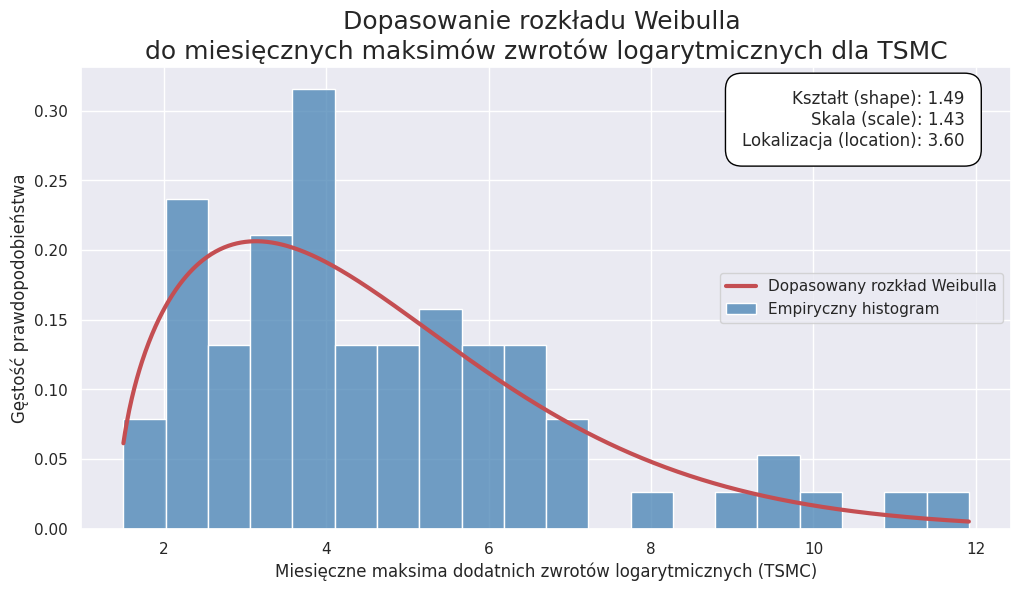

In [50]:
shape_param = params_weibull_tsmc[0]  # Parametr kształtu (shape)
scale_param = params_weibull_tsmc[1]  # Parametr skali (scale)
loc_param = params_weibull_tsmc[2]   # Parametr lokalizacji (location)

plt.figure(figsize=(12, 6))

# Dodanie parametrów Weibulla na wykresie
param_text = f'Kształt (shape): {shape_param:.2f}\nSkala (scale): {scale_param:.2f}\nLokalizacja (location): {loc_param:.2f}'
plt.text(0.95, 0.95, param_text, ha='right', va='top', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))

sns.histplot(monthly_maxima_tsmc_raw, bins=20, kde=False, stat="density", color="steelblue", label='Empiryczny histogram')
plt.plot(x_vals_tsmc, weibull_pdf_tsmc, 'r-', lw=3, label='Dopasowany rozkład Weibulla')
plt.title('Dopasowanie rozkładu Weibulla \ndo miesięcznych maksimów zwrotów logarytmicznych dla TSMC', fontsize=18)
plt.xlabel('Miesięczne maksima dodatnich zwrotów logarytmicznych (TSMC)', fontsize=12)
plt.ylabel('Gęstość prawdopodobieństwa', fontsize=12)
plt.legend()
plt.show()

# Najlepszy dla Samsung

# Dopasowanie rozkładu ExponWeib

In [51]:
params_exponweib_samsung = st.exponweib.fit(monthly_maxima_samsung_raw)
params_exponweib_samsung

(np.float64(0.7413116664172301),
 np.float64(1.6580366692752655),
 np.float64(1.257867735602172),
 np.float64(2.7942978812412385))

In [52]:
x_vals_samsung = np.linspace(min(monthly_maxima_samsung_raw), max(monthly_maxima_samsung_raw), 1000)
exponweib_pdf_samsung = st.exponweib.pdf(x_vals_samsung, *params_exponweib_samsung)

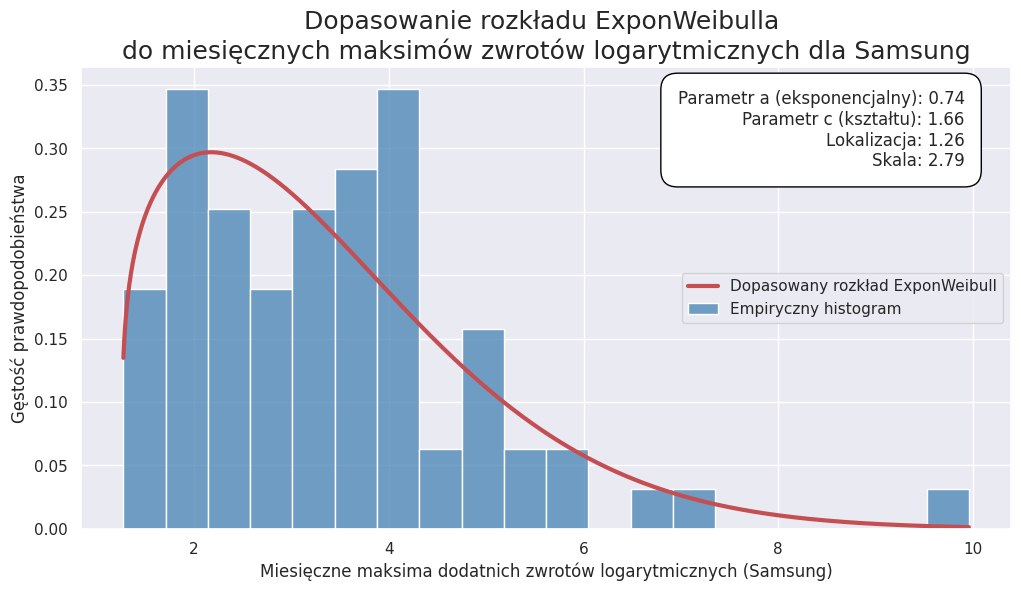

In [54]:
a_param = params_exponweib_samsung[0]  # Parametr eksponencjalny (a)
c_param = params_exponweib_samsung[1]  # Parametr Weibulla (c)
loc_param = params_exponweib_samsung[2]  # Lokalizacja (loc)
scale_param = params_exponweib_samsung[3]  # Skala (scale)

plt.figure(figsize=(12, 6))

# Dodanie parametrów Weibulla na wykresie
param_text = f'Parametr a (eksponencjalny): {a_param:.2f}\nParametr c (kształtu): {c_param:.2f}\nLokalizacja: {loc_param:.2f}\nSkala: {scale_param:.2f}'
plt.text(0.95, 0.95, param_text, ha='right', va='top', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))

sns.histplot(monthly_maxima_samsung_raw, bins=20, kde=False, stat="density", color="steelblue", label='Empiryczny histogram')
plt.plot(x_vals_samsung, exponweib_pdf_samsung, 'r-', lw=3, label='Dopasowany rozkład ExponWeibull')
plt.title('Dopasowanie rozkładu ExponWeibulla \ndo miesięcznych maksimów zwrotów logarytmicznych dla Samsung', fontsize=18)
plt.xlabel('Miesięczne maksima dodatnich zwrotów logarytmicznych (Samsung)', fontsize=12)
plt.ylabel('Gęstość prawdopodobieństwa', fontsize=12)
plt.legend()
plt.show()